In [1]:
from __future__ import print_function, unicode_literals

import pickle
import os
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from PIL import Image
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from nets.Unet import unet

import pandas as pd
from Hands_Dataset import Hands, Hands_test
import torchvision.transforms as transforms

### Training parameters

In [2]:
batch_size = 32
num_epochs = 50
print_freq = 100
learning_rate = 0.001

### Data loading

In [3]:
train_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.0341, 0.0335, 0.0327), (0.0189, 0.0183, 0.0200)) 
    ])

train_dataset = Hands(csv_file="dataset.csv",root_dir="training/color/",transform=train_transformation)
test_dataset = Hands_test(csv_file="test_dataset.csv",root_dir="evaluation/color/",transform=train_transformation)
val_dataset = Hands_test(csv_file="val_dataset.csv",root_dir="evaluation/color/",transform=train_transformation)

train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

### Training Routine

In [4]:
model = unet(pretrained=False,n_channels=3,n_classes=2)
model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate, amsgrad=True)

# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    model.train()
    for i, (images,labels) in enumerate(train_loader):
        model.train()
        # Run the forward pass
        outputs = model(images.cuda())
        
        #Loss
        loss = criterion(F.log_softmax(outputs), labels.cuda())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % print_freq == 0:
            
            # Test the model
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                iou_score_list =[]
                for n, (images, labels) in enumerate(val_loader):
                    out = model(images.cuda())
                    pred = out                
                    mask = pred[n][1]
                    mask = np.array((mask).cpu().detach())
                    mask = (mask>0.011).astype(np.uint8)

                    #IoU
                    intersection = mask-abs(np.array(labels[n])-mask)
                    intersection =(intersection > 0).astype(np.uint8)

                    union = abs(np.array(labels[n])+mask)
                    union = (union > 0).astype(np.uint8)

                    iou_score_list.append( sum(sum(intersection))/ sum(sum(union)))

                iou_score = np.mean(np.array(iou_score_list))
                acc_list.append(iou_score)
            
            torch.save(model.state_dict(),"nets/checkpoint_HandSegNet.pth.tar")
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Validation_Acc: {:.4f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),iou_score*100))   
            
            
            
#Loss&Accuracy plot
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(np.convolve(len(loss_list), loss_list))
plt.legend(['loss'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.figure(figsize=(20,10))
plt.subplot(2, 1, 2)
plt.plot(np.convolve(len(acc_list), acc_list))
plt.legend(['mean IoU score'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('mean Iou sore')

plt.show()

/home/linux/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/linux/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/linux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50], Step [100/1290], Loss: 0.4067, Validation_Acc: 1.9318%
Epoch [1/50], Step [200/1290], Loss: 0.3612, Validation_Acc: 1.9327%
Epoch [1/50], Step [300/1290], Loss: 0.3547, Validation_Acc: 2.0989%
Epoch [1/50], Step [400/1290], Loss: 0.3539, Validation_Acc: 17.1365%
Epoch [1/50], Step [500/1290], Loss: 0.3433, Validation_Acc: 15.3976%
Epoch [1/50], Step [600/1290], Loss: 0.3405, Validation_Acc: 30.5358%
Epoch [1/50], Step [700/1290], Loss: 0.3358, Validation_Acc: 23.9736%
Epoch [1/50], Step [800/1290], Loss: 0.3383, Validation_Acc: 45.8333%
Epoch [1/50], Step [900/1290], Loss: 0.3292, Validation_Acc: 36.1895%
Epoch [1/50], Step [1000/1290], Loss: 0.3319, Validation_Acc: 40.3378%
Epoch [1/50], Step [1100/1290], Loss: 0.3312, Validation_Acc: 31.1343%
Epoch [1/50], Step [1200/1290], Loss: 0.3275, Validation_Acc: 44.4298%
Epoch [2/50], Step [100/1290], Loss: 0.3394, Validation_Acc: 34.0380%
Epoch [2/50], Step [200/1290], Loss: 0.3313, Validation_Acc: 33.6056%
Epoch [2/50], Step [

Epoch [10/50], Step [1000/1290], Loss: 0.3174, Validation_Acc: 75.2670%
Epoch [10/50], Step [1100/1290], Loss: 0.3180, Validation_Acc: 66.3882%
Epoch [10/50], Step [1200/1290], Loss: 0.3171, Validation_Acc: 66.6390%
Epoch [11/50], Step [100/1290], Loss: 0.3176, Validation_Acc: 69.3276%
Epoch [11/50], Step [200/1290], Loss: 0.3180, Validation_Acc: 74.1463%
Epoch [11/50], Step [300/1290], Loss: 0.3181, Validation_Acc: 67.7551%
Epoch [11/50], Step [400/1290], Loss: 0.3188, Validation_Acc: 72.3161%
Epoch [11/50], Step [500/1290], Loss: 0.3173, Validation_Acc: 66.2285%
Epoch [11/50], Step [600/1290], Loss: 0.3175, Validation_Acc: 69.6098%
Epoch [11/50], Step [700/1290], Loss: 0.3177, Validation_Acc: 75.9484%
Epoch [11/50], Step [800/1290], Loss: 0.3172, Validation_Acc: 75.0375%
Epoch [11/50], Step [900/1290], Loss: 0.3171, Validation_Acc: 77.9125%
Epoch [11/50], Step [1000/1290], Loss: 0.3193, Validation_Acc: 78.7677%
Epoch [11/50], Step [1100/1290], Loss: 0.3170, Validation_Acc: 67.7072%
E

Epoch [20/50], Step [500/1290], Loss: 0.3167, Validation_Acc: 81.6330%
Epoch [20/50], Step [600/1290], Loss: 0.3165, Validation_Acc: 81.5631%
Epoch [20/50], Step [700/1290], Loss: 0.3161, Validation_Acc: 85.7642%
Epoch [20/50], Step [800/1290], Loss: 0.3183, Validation_Acc: 73.8865%
Epoch [20/50], Step [900/1290], Loss: 0.3162, Validation_Acc: 80.3758%
Epoch [20/50], Step [1000/1290], Loss: 0.3163, Validation_Acc: 85.2094%
Epoch [20/50], Step [1100/1290], Loss: 0.3159, Validation_Acc: 84.2449%
Epoch [20/50], Step [1200/1290], Loss: 0.3163, Validation_Acc: 85.7998%
Epoch [21/50], Step [100/1290], Loss: 0.3160, Validation_Acc: 84.3622%
Epoch [21/50], Step [200/1290], Loss: 0.3173, Validation_Acc: 82.1028%
Epoch [21/50], Step [300/1290], Loss: 0.3165, Validation_Acc: 84.6829%
Epoch [21/50], Step [400/1290], Loss: 0.3176, Validation_Acc: 84.9053%
Epoch [21/50], Step [500/1290], Loss: 0.3164, Validation_Acc: 84.6003%
Epoch [21/50], Step [600/1290], Loss: 0.3164, Validation_Acc: 86.4186%
Epo

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(he

KeyboardInterrupt: 

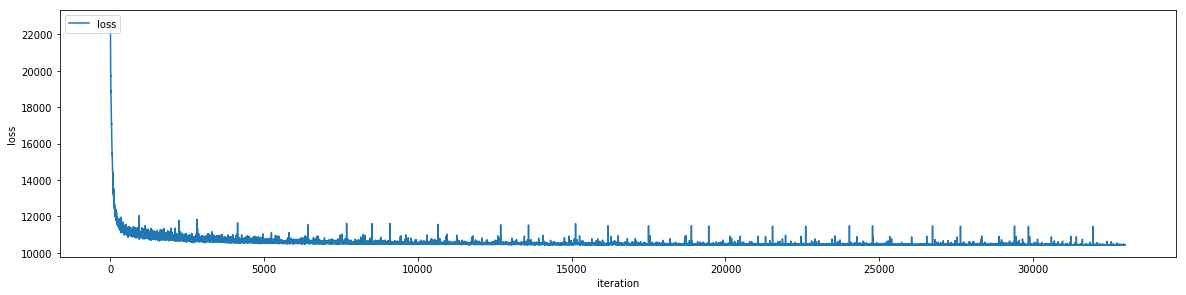

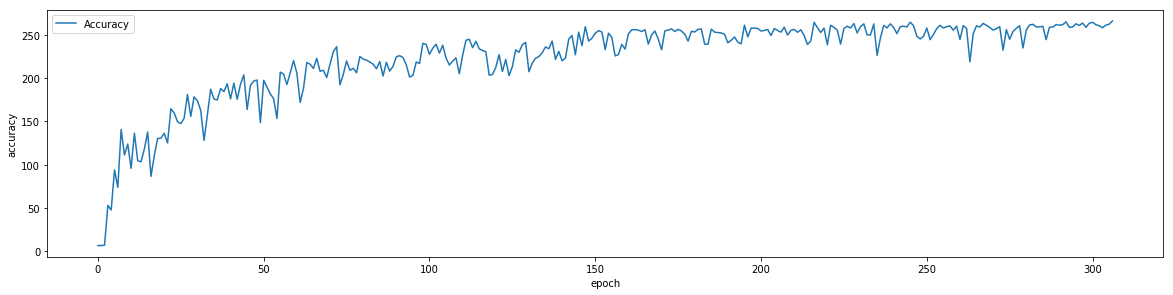

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(np.convolve(len(loss_list), loss_list))
plt.legend(['loss'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.figure(figsize=(20,10))
plt.subplot(2, 1, 2)
plt.plot(np.convolve(len(acc_list), acc_list))
plt.legend(['Accuracy'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

### Evaluation

/home/linux/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/linux/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy: 93.64161849710982%


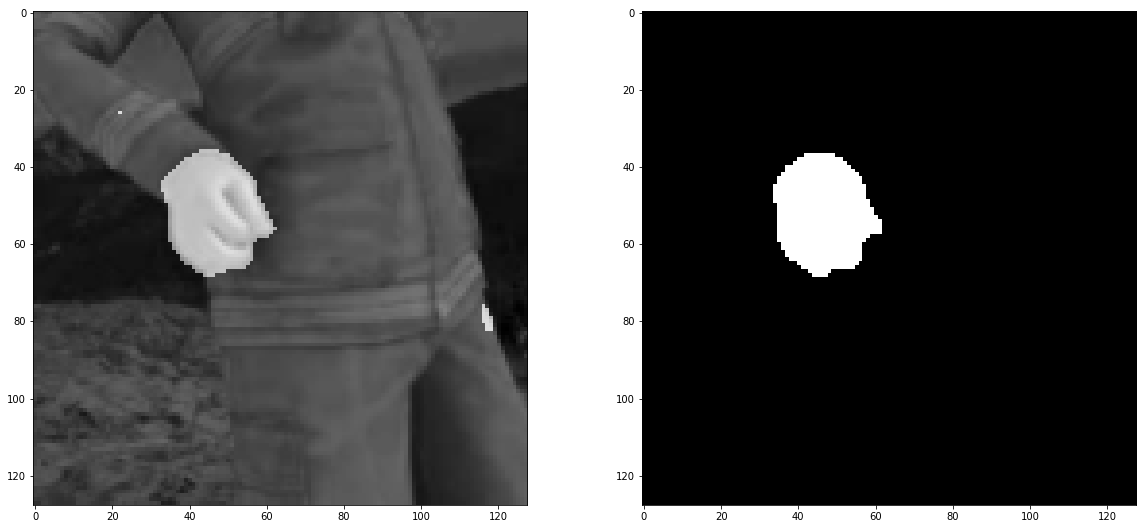

Accuracy: 92.66055045871559%


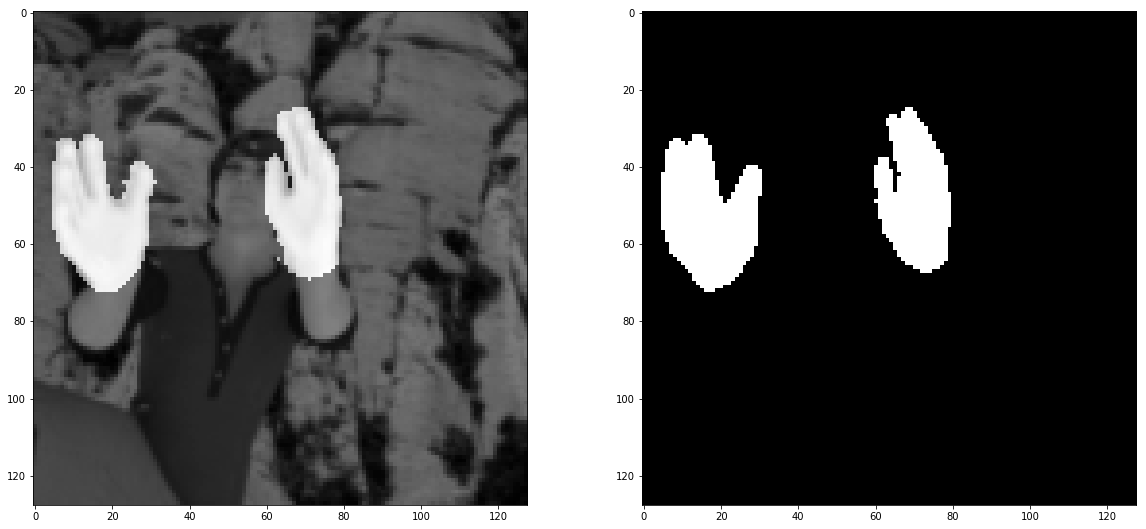

Accuracy: 86.51685393258427%


Traceback (most recent call last):
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/linux/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(he

KeyboardInterrupt: 

In [4]:
batch_size = 1
model = unet(pretrained=True,n_channels=3,n_classes=2)

model.cuda()
model.eval()
classIndex=1

i = 0
for images, labels in test_loader:
        out = model(images.cuda())
        n = 0
        for image in images:
                image = np.array(image)
                pred = out                
                mask = pred[n][1]
                mask = np.array((mask).cpu().detach())
                mask = (mask>0.011).astype(np.uint8)
                fig = plt.figure(figsize=(20,20))
                ax1 = plt.subplot(221)
                ax1.imshow(image[0],interpolation='nearest',cmap="gray")
                ax1.imshow(mask, alpha=0.5,cmap="gray")
                    
                intersection = mask-abs(np.array(labels[n])-mask)
                intersection =(intersection > 0).astype(np.uint8)
                
                union = abs(np.array(labels[n])+mask)
                union = (union > 0).astype(np.uint8)
                
                iou_score = sum(sum(intersection))/ sum(sum(union))
                print("Accuracy: " +str(iou_score*100)+ "%")
                
                ax2 = plt.subplot(222)
                ax2.imshow(labels[n],cmap="gray")
                
                
                plt.savefig("test_perf", dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
                
                plt.show()
                n+=1

        i += 1

36 31
58 36


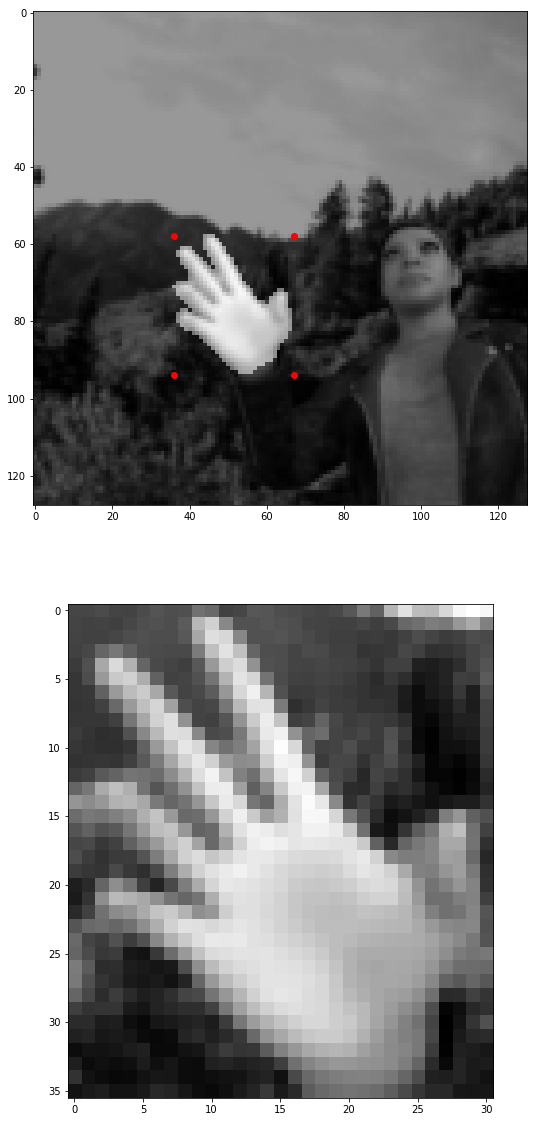

In [28]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,1,1)
ax1.imshow(image[0],cmap="gray")
ax1.imshow(mask,alpha=0.4,cmap="gray")

mask_n = mask*255

rect = cv2.boundingRect(mask_n)               # function that computes the rectangle of interest

ax1.plot((rect[0]+rect[2]),(rect[1]+rect[3]),'ro')
ax1.plot((rect[0]),(rect[1]+rect[3]),'ro')
ax1.plot((rect[0]+rect[2]),(rect[1]),'ro')
ax1.plot((rect[3]),(rect[1]),'ro')

print(rect[0],rect[2])
print(rect[1],rect[3])

cropped_img = image[0][rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]  # crop the image to the desired rectangle

ax2 = plt.subplot(2,1,2)
ax2.imshow(cropped_img,cmap="gray")


In [4]:
import cv2

In [5]:
model = unet(pretrained=True,n_channels=3,n_classes=2)

model.cuda()
model.eval()
classIndex=1

cam_transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128))])

In [ ]:
cv2.namedWindow("preview",cv2.WINDOW_NORMAL)
cv2.resizeWindow('preview', 600,600)
cv2.namedWindow("mask",cv2.WINDOW_NORMAL)
cv2.resizeWindow('mask', 600,600)
cv2.namedWindow("hand",cv2.WINDOW_NORMAL)
cv2.resizeWindow('hand', 600,600)

vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    
    original = cam_transformation(frame)
    original = np.array(original)
    original = np.reshape(original,(128,128,3))
    
    frame = train_transformation(frame)
    frame = frame.view(1,3,128,128)
    
    out = model(frame.cuda())
    if (out.shape != None):
        
        pred = out                
        mask = pred[0][1]
        mask = np.array((mask).cpu().detach())
        mask = (mask>0.8).astype(np.uint8)
        
        out = torch.max(out.data, 1)
        out = np.array(out[1].cpu().detach())
        
        
        mask_n = mask*255
        
        rect = cv2.boundingRect(mask_n)               # function that computes the rectangle of interest

        #ax1.plot((rect[0]+rect[2]),(rect[1]+rect[3]),'ro')
        #ax1.plot((rect[0]),(rect[1]+rect[3]),'ro')
        #ax1.plot((rect[0]+rect[2]),(rect[1]),'ro')
        #ax1.plot((rect[3]),(rect[1]),'ro')
        
        cropped_img = original[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]  # crop the image to the desired rectangle
        if (cropped_img.shape[0] > 0):
            if (cropped_img.shape[1] > 0):
                cv2.imshow("hand",np.array(cropped_img))

        
        cv2.imshow("preview", np.array(original))
        cv2.imshow("mask",mask*255)

    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
        
vc.release()
cv2.destroyWindow("preview")
cv2.destroyWindow("mask")
cv2.destroyWindow("hand")

(1, 2, 128, 128)


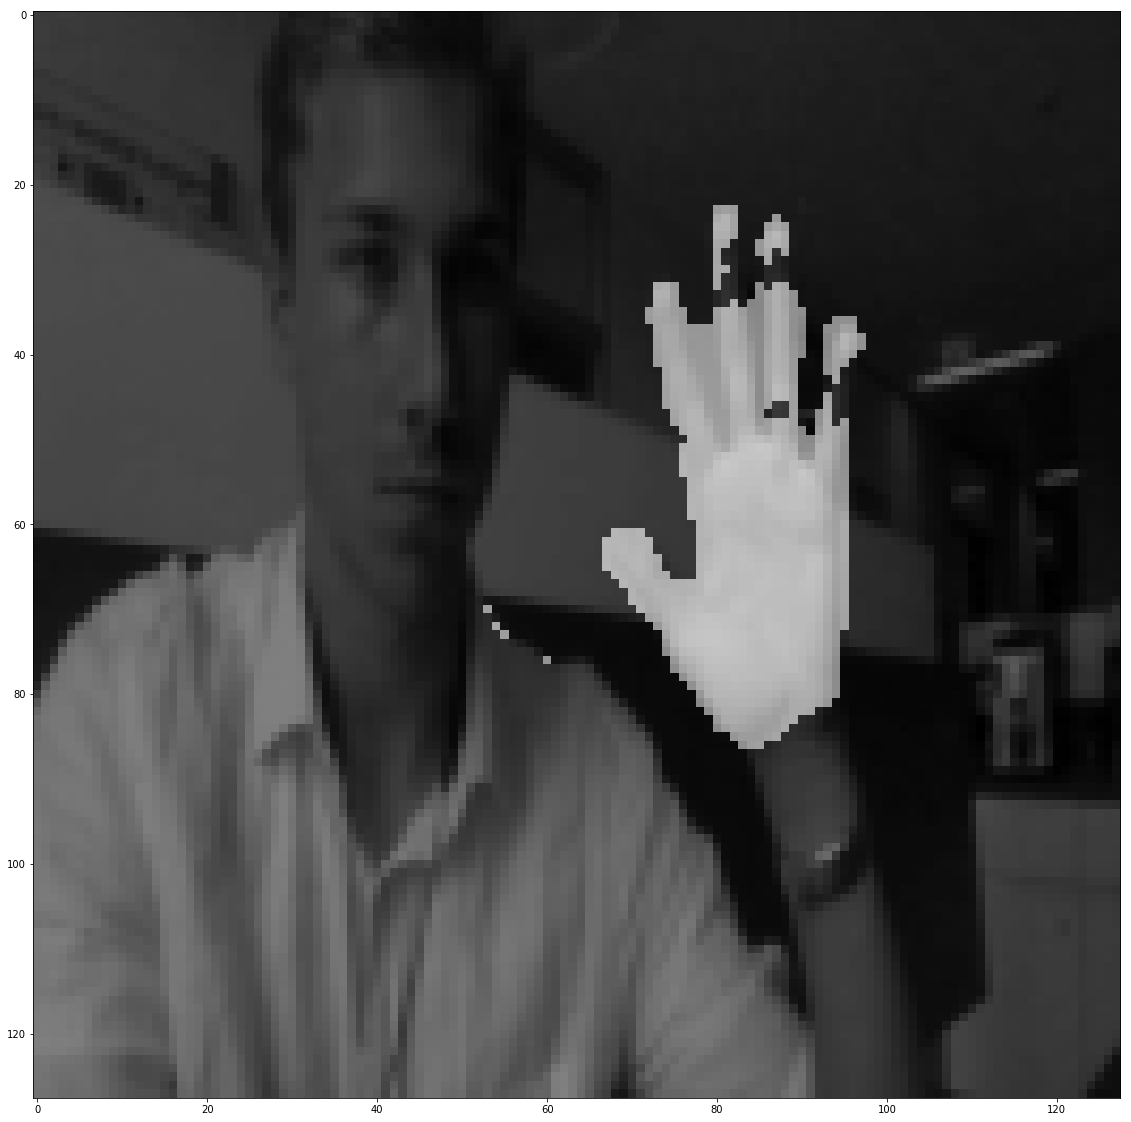

In [33]:
batch_size = 1
model = unet(pretrained=True,n_channels=3,n_classes=2)

model.cuda()
model.eval()
classIndex=1

i = 0
image = cv2.imread("2019-07-17-122500.jpg")

image = train_transformation(image)
image = np.reshape(image,(1,3,128,128))


out = model(image.cuda())

image = np.array(image)
pred = out                
mask = pred
mask = np.array((mask).cpu().detach())
mask = (mask>0.011).astype(np.uint8)

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(111)
print(mask.shape)
ax1.imshow(image[0][0],interpolation='nearest',cmap="gray")
ax1.imshow(mask[0][1], alpha=0.5,cmap="gray")
plt.savefig("test_perf_real", dpi=None, facecolor='w', edgecolor='w',
orientation='portrait', papertype=None, format=None,
transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None, metadata=None)

intersection = mask-abs(np.array(labels[n])-mask)
intersection =(intersection > 0).astype(np.uint8)

union = abs(np.array(labels[n])+mask)
union = (union > 0).astype(np.uint8)

iou_score = sum(sum(intersection))/ sum(sum(union))


plt.show()
n+=1

In [31]:
plt.savefig("test_perf_real", dpi=None, facecolor='w', edgecolor='w',
orientation='portrait', papertype=None, format=None,
transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None, metadata=None)

<Figure size 432x288 with 0 Axes>